# Step 1

As Our client is looking for a very short maturity for her derivative
(around 15 days). we are going to calibrate a Classic Heston (1993) model (without jumps) to the observed market prices for both call and put options. we will use the Lewis (2001) approach with a regular MSE error function. We are considering a constant annual risk-rate of 1.50%. And We are also assuming 1 year have 250 trading days.

## 1.a Calibrating Heston (1993) Model Via Lewis (2001) Appraoch



In [12]:
%pip install skimpy 

  Using cached skimpy-0.0.15-py3-none-any.whl.metadata (28 kB)
  Using cached polars-0.20.31-cp38-abi3-win_amd64.whl.metadata (14 kB)
  Using cached typeguard-4.2.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached skimpy-0.0.15-py3-none-any.whl (16 kB)
Using cached typeguard-4.2.1-py3-none-any.whl (34 kB)
   ---------------------------------------- 0.0/28.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/28.8 MB 991.0 kB/s eta 0:00:30
   ---------------------------------------- 0.1/28.8 MB 1.4 MB/s eta 0:00:20
   ---------------------------------------- 0.3/28.8 MB 2.0 MB/s eta 0:00:15
   ---------------------------------------- 0.3/28.8 MB 1.8 MB/s eta 0:00:17
    --------------------------------------- 0.6/28.8 MB 2.3 MB/s eta 0:00:13
   - -------------------------------------- 0.8/28.8 MB 3.0 MB/s eta 0:00:10
   - -------------------------------------- 1.2/28.8 MB 3.4 MB/s eta 0:00:09
   -- --


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute, fmin
from scipy.integrate import quad


### Heston (1993) Characteristic Function

We are going to start with a major ingredient for Fourier transform methods such as Lewis (2001) is knowledge of the characteristic function for the underlying process. We will present here the closed-form expression; you can check the original Heston (1993) paper or Gatheral (2006) to see the derivation of this characteristic function.

The characteristic function of the Heston (1993) model is given by:

$$
\
\begin{equation*}
  \varphi^{H} (u, T) = e^{H_1(u, T)+H_2(u,T)\nu_0}
\end{equation*}
$$
\
where

$$
\
\begin{equation*}
  H_1 (u, T) \equiv r_0 uiT + \frac{c_1}{\sigma_\nu^2}\Biggl\{ (\kappa_\nu - \rho \sigma_\nu ui+c_2) T - 2 log \left[ \frac{1-c_3e^{c_2T}}{1-c_3} \right] \Biggl\}
\end{equation*}
$$
$$
\
\begin{equation*}
  H_2 (u, T) \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\sigma_\nu^2} \left[ \frac{1-e^{c_2T}}{1-c_3e^{c_2T}} \right]
\end{equation*}
$$
$$
\
\begin{equation*}
  c_1 \equiv \kappa_\nu \theta_\nu
\end{equation*}
$$
$$
\
\begin{equation*}
  c_2 \equiv - \sqrt{(\rho \sigma_\nu ui - \kappa_\nu)^2 - \sigma_\nu^2(-ui-u^2) }
\end{equation*}
$$
$$
\
\begin{equation*}
  c_3 \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\kappa_\nu - \rho \sigma_\nu ui - c_2}
\end{equation*}
$$

\
we have created a function in Python that simplifies its calculations every time:

In [15]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

Now that we have our characteristic function, let's move on to another important step in the pricing process.

### Integral Value in Lewis (2001)
We also need to get a value for the integral in Lewis (2001):

$$
\
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$
\
we have used this expression for the integral is the same one we used for Black-Scholes, but here that the expression for the characteristic function has changed.


In [16]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

### Calculating The Value of the Integral and call value

Now, we will need to numerically compute the value of the aforementioned integral. As before, we will use the quadrature method (*quad*) included in the scipy package (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)

In [17]:
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [18]:
def H93_Put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    call = H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    Put = call + (K * np.exp(-r * T)) - S0

    return Put

### Pricing Heston (1993) Via Lewis (2001)

For pricing the call and put option we are going to use some standard parameters.

In [19]:
# Option Parameters
S0 = 100.0
K = 100.0
T = 1.0
r = 0.02

# Heston(1993) Parameters
kappa_v = 1.5
theta_v = 0.02
sigma_v = 0.15
rho = 0.1
v0 = 0.01


print(
    "Heston (1993) Call Option Value:   $%10.4f "
    % H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
)

print(
    "Heston (1993) put Option Value:   $%10.4f "
    % H93_Put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
)

Heston (1993) Call Option Value:   $    5.7578 
Heston (1993) put Option Value:   $    3.7777 


As we have seen how to model works we are now going to work on full calibration process with real market data.

### Heston Model Calibaration

In this section we are going to fully calibrate Heston model with real data, we will first process our options data accrding to our requirement, Let's preprocess our data in the next section.

#### Options Data Preprocessing

Here we have loaded our data.

In [20]:
df = pd.read_csv(r"Data\MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx - 1.csv") 
df.head()

,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


Here We are Skimpy package (https://pypi.org/project/skimpy/) to get all the necessary summary statistics about our dataframe at one place.

In [21]:
from skimpy import skim

skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 30     │ │ float64     │ 2     │                                                          │
│ │ Number of columns │ 4      │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Days to maturity    │   0 │     0 │     65 │  43.75 │     15 │     15 │     60 │    120 │    120 │ ▇ ▇  ▇  │  │
│ │ Strike              │   0 │     0 │  232.5 │  3.596 │  227.5 │    230 │  232.5 │    235 │  237.5 │ ▇▇ ▇▇▇  │  │
│ │ Price               │   0 │     0 │  14.07 │  6.124 │   4.32 │  9.098 │  14.93 │  17.54 │  27.92 │ ▇▅▆▇▂▂  │  │
│ └─────────────────────┴─────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Type                      │       0 │          0 │                            1 │                       30 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Our stock SM Energy Company is currenlty trading at $232.90, so that will be the value of S0, After that we will we will filter our dataframe to include on data which have Days to maturity of 15 days as that is our requirement for calibration. Next we will add time left to maturity and constant risk-free rate to our dataframe.

In [22]:
S0 = 232.90


options = df[(df["Days to maturity"] == 15)].copy()

In [23]:
for row, option in options.iterrows():
    T = (option["Days to maturity"] / 250.0) # 1 year = 250 trading days
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.015      #Constant Annual risk-free rate = 1.50%

In [24]:
options.head()

,Days to maturity,Strike,Price,Type,T,r
0,15,227.5,10.52,C,0.06,0.015
1,15,230.0,10.05,C,0.06,0.015
2,15,232.5,7.75,C,0.06,0.015
3,15,235.0,6.01,C,0.06,0.015
4,15,237.5,4.75,C,0.06,0.015


#### Calibration Process

Now this is our main section of calibration process, we also need to define some additional function to optimize the model parameters so that they work well on observed data.

First, we will introduce a function that will evaluate the error the model makes with respect to observed data given certain parameters. As usual, we will rely on a **mean squared error (MSE) function**. We will also define some initial values for the calibration parameters:

In [25]:
i = 0
min_MSE = 500
min_MSE2 = 500

In [26]:
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE, min_MSE2
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    se2 = []

    for row, option in options.iterrows():
      if option["Type"] == "C":
            model_value = H93_call_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
            )
            se.append((model_value - option["Price"]) ** 2)

      if option["Type"] == "P":
            model_value = H93_call_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
            )
            se2.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    MSE2 = sum(se2) / len(se2)

    min_MSE = min(min_MSE, MSE)
    min_MSE2 = min(min_MSE2, MSE2)

    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| Call MSE: %7.3f | Min Call MSE: %7.3f" % (MSE, min_MSE))
        print("%4d |" % i, np.array(p0), "| Put MSE: %7.3f | Min Put MSE: %7.3f" % (MSE2, min_MSE2))

    i += 1

    return MSE + MSE2

Next, we will need a function that performs the **optimization process**. In other words, it optimizes the model parameters so as to minimize the error function with respect to market data. We will do this in 2 steps in order to look for faster convergence of the prices to market quotes. First, we will use the `brute` function of scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html), that allows the calibration to focus on most sensible ranges. Once these are declared, we can dig deeper into the specific regions and get the actual parameters more accurately with the `fmin` function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html).

In [27]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

#### Results

Now that we have all the necessary ingredients, let's see how our calibration algorithm performs. For that, given the way we structured things before, we just need to call our *H93_calibration_full()* function. This will give us each of the different outputs from calibration, including the values given to the different parameters in the model.

In [28]:
Para = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | Call MSE:  23.560 | Min Call MSE:  23.560
   0 | [ 2.5   0.01  0.05 -0.75  0.01] | Put MSE:  24.326 | Min Put MSE:  24.326


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\Lenovo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\polars\\polars.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/28.8 MB ? eta -:--:--
   ---------------------------------------- 0.2/28.8 MB 3.6 MB/s eta 0:00:09
    --------------------------------------- 0.5/28.8 MB 2.8 MB/s eta 0:00:11
    --------------------------------------- 0.6/28.8 MB 3.0 MB/s eta 0:00:10
    --------------------------------------- 0.6/28.8 MB 2.7 MB/s eta 0:00:11
    --------------------------------------- 0.6/28.8 MB 2.5 MB/s eta 0:00:12
    --------------------------------------- 0.6/28.8 MB 2.5 MB/s eta 0:00:12
   - -------------------------------------- 1.0/28.8 MB 2.2 MB/s eta 0:00:13
   - -------------------------------------- 1.0/28.8 MB 2.2 MB/s eta 0:00:13
   - -------------------------------------- 1.1/28.8 MB 2.1 MB/s eta 0:00:14
   - -------------------------------------- 1.3/28.8 MB 2.1 MB/s eta 0:00:14
   - -------------------------------------- 1.4/28.8 MB 2.2 MB/s eta 0:00:13
   -- ------------------------------------- 1.6/28.8 MB 2.3 MB/s eta 0:00:12
   -- 

In [29]:
Para

array([ 5.38064479e+00,  8.68040384e-02,  4.54280985e-05, -6.12233923e-03,
        8.71998758e-02])

Now we have finally calibrated our parameters to market values.

The results from this calibration give us the following values for the parameters in the Heston (1993) model:

$\kappa_\nu = 5.379$

$\theta_\nu = 0.086$

$\sigma_\nu = 0.000$

$\rho = -0.006$

$\nu_0 = 0.087$

The next step will be simply using these parameters to price the option we want.but before that first let's plot our results to check how our model calibration have worked.

In [30]:
def generate_plot_call(Para, options):
    # Extract parameters from the optimization result
    kappa_v, theta_v, sigma_v, rho, v0 = Para

    # Calculate model prices
    options["Model"] = 0.0
    for idx, option in options.iterrows():
        if option["Type"] == "C":
            options.loc[idx, "Model"] = H93_call_value(
                S0, option["Strike"], option["T"], option["r"], kappa_v, theta_v, sigma_v, rho, v0
            )

    # Plotting the results for maturity 15 and type C
    subset = options[(options["Type"] == "C")]
    subset.plot(x="Strike", y=["Price", "Model"], style=["b-", "ro"], title="Maturity 15 days")
    plt.ylabel("Option Value")
    plt.xlabel("Strike Price")
    plt.show()

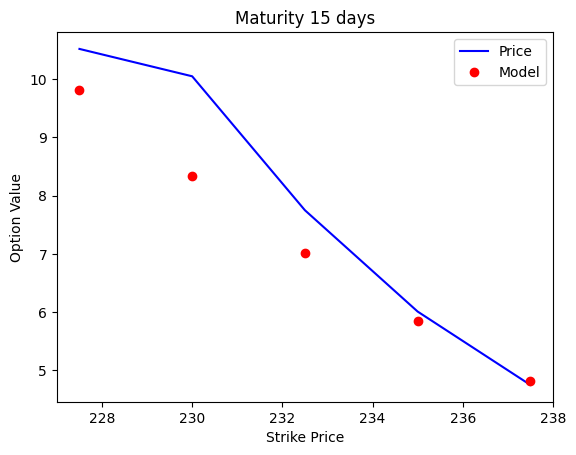

In [31]:
generate_plot_call(Para, options)

In [32]:
def generate_plot_put(Para, options):
    # Extract parameters from the optimization result
    kappa_v, theta_v, sigma_v, rho, v0 = Para

    # Calculate model prices
    options["Model"] = 0.0
    for idx, option in options.iterrows():
        if option["Type"] == "P":
            options.loc[idx, "Model"] = H93_Put_value(
                S0, option["Strike"], option["T"], option["r"], kappa_v, theta_v, sigma_v, rho, v0
            )

    # Plotting the results for maturity 15 and type C
    subset = options[(options["Type"] == "P")]
    subset.plot(x="Strike", y=["Price", "Model"], style=["b-", "ro"], title="Maturity 15 days")
    plt.ylabel("Option Value")
    plt.xlabel("Strike Price")
    plt.show()

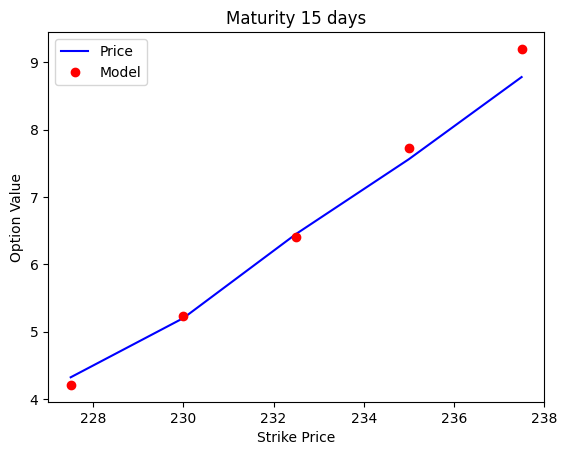

In [33]:
generate_plot_put(Para, options)

## 1.b Calibrating Heston (1993) Model Via the Carr-Madan (1999) pricing approach

In this section we will use the Carr-Madan (1999) pricing approach. The Carr-Madan approach uses the Fast Fourier Transform (FFT) to price options, which brings several advantages comparig with the Lewis approach ap;ied in previous section (a):

 - Efficiency:  The FFT algorithm is computationally efficient with a time complexity of
𝑂(𝑁log𝑁), making it well-suited for the batch processing and pricing of many options quickly.


 - Numerical Stability: By leveraging the FFT, the Carr-Madan method can handle a large number of integration points stably, leading to more accurate results.

- Simplicity: The method is relatively straightforward to implement using existing FFT libraries. Moreover it is well-suited for pricing exotic options and payoffs that can be expressed in terms of Fourier transforms.

In order to apply this approach we will use FFT to the integral in the call option price derived by Carr and Madan (1999):

$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{H93} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$


In [34]:
def H93_value_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, option_type):
    """
    option price in Heston (1993) under FFT

    H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)

    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    if option_type == "C":
        return CallValue
    elif option_type == "P":
        PutValue = CallValue + (K * np.exp(-r * T)) - S0
        return PutValue

    return None

### Model Calibration
We will use provided market data to calibrate parameters of the Heston model

In [35]:
options =  (df.query('`Days to maturity` == 15')
             .assign(t=lambda x: x["Days to maturity"] / 250,
                     r=0.15,
                     S0 = S0
                    )
            )

#### Calibration Process

The calibration process for the Heston model aims to determine the optimal parameters for the model by minimizing the Mean Square Error (MSE) between market prices and model prices. Initially, the H93_value_FFT function, which is responsible for calculating option prices using the Heston model, is defined. The objective function is then created to compute MSE. This function iterates through market data, computes model prices for given market conditions and parameters, and calculates the squared errors between these model prices and actual market prices. The RMSE, a measure of the average discrepancy between model and market prices, is then derived from these squared errors.

Market data, comprising columns for initial stock price (S0), strike price (K), time to maturity (T), risk-free rate (r), option type, and market price, is structured based on a pandas DataFrame. An initial guess for the parameters of the Heston model, including the speed of mean reversion (kappa_v), long-term variance (theta_v), volatility of variance (sigma_v), correlation between asset price and variance (rho), and initial variance (v0). Selected bounds ensure the parameters remain within usually observed ranges during the optimization process.

The scipy.optimize.minimize function is then employed to minimize the MSE, effectively calibrating the Heston model parameters to best fit the given market data. The result of the optimization yields the optimal values for kappa_v, theta_v, sigma_v, rho, and v0, which are then extracted and printed. These optimized parameters are applied to the DataFrame to calculate option prices using the calibrated H93_value_FFT function.

In [36]:
from scipy.optimize import minimize

def objective(params, market_data):
    """
    Objective function to minimize MSE
    """
    kappa_v, theta_v, sigma_v, rho, v0 = params

    errors = []
    for data in market_data:
        S0, K, T, r, option_type, market_price = data
        model_price = H93_value_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, option_type)
        errors.append((market_price - model_price) ** 2)

    mse = np.mean(errors)
    return mse

# Initial guess for the parameters
initial_guess = [5.0, 0.8, 0.3, -0.7, 0.04]

# # Bounds for the parameters
bounds = [
    (0.0001, 10),  # kappa_v bounds
    (0.0001, 1),   # theta_v bounds
    (0.0001, 1),   # sigma_v bounds
    (-1, 1),     # rho bounds
    (0.01, 0.5)  # v0 bounds
]

#prepare numpy array with market data for S0, K, T, r, option_type, market_price
data_columns = ['S0', 'Strike', 't', 'r', 'Type', 'Price']
market_data = options[data_columns].values


# Minimize the MSE to find the best parameters
result = minimize(objective, initial_guess, args=(market_data,), bounds=bounds)

# Extract the optimized parameters
kappa_v_opt, theta_v_opt, sigma_v_opt, rho_opt, v0_opt = result.x

print(f"Optimized parameters: kappa_v={kappa_v_opt}, theta_v={theta_v_opt}, sigma_v={sigma_v_opt}, rho={rho_opt}, v0={v0_opt}")
print(f"MSE: {result.fun}")

Optimized parameters: kappa_v=7.211202515417182, theta_v=0.0001, sigma_v=1.0, rho=0.7689237411322527, v0=0.01
MSE: 0.47493933768842334


Now we have finally calibrated our parameters to market values.

The results from this calibration give us the following values for the parameters in the Heston (1993) model:

$\kappa_\nu = 7.21$

$\theta_\nu = 0.0001$

$\sigma_\nu = 1.00$

$\rho = 0.768$

$\\v_0 = 0.01$

### Visualisation of results
On the next step we, using the apply method to compute model prices for each row in the DataFrame, created a new column, price_calc, which contains these calculated prices. The final DataFrame, now includes both market prices and model prices calculated with the optimized parameters, provides a comprehensive view of the calibration accuracy and effectiveness.

In [37]:
# Apply the optimized parameters to the DataFrame to calculate prices
options['price_calc'] = options.apply(lambda row: H93_value_FFT(row['S0'], row['Strike'], row['t'], row['r'],
                                        kappa_v_opt, theta_v_opt, sigma_v_opt, rho_opt, v0_opt, row['Type']), axis=1)
options

,Days to maturity,Strike,Price,Type,t,r,S0,price_calc
0,15,227.5,10.52,C,0.06,0.15,232.9,11.564888
1,15,230.0,10.05,C,0.06,0.15,232.9,9.738888
2,15,232.5,7.75,C,0.06,0.15,232.9,8.131079
3,15,235.0,6.01,C,0.06,0.15,232.9,6.809289
4,15,237.5,4.75,C,0.06,0.15,232.9,5.786548
15,15,227.5,4.32,P,0.06,0.15,232.9,4.126574
16,15,230.0,5.20,P,0.06,0.15,232.9,4.778175
17,15,232.5,6.45,P,0.06,0.15,232.9,5.647967
18,15,235.0,7.56,P,0.06,0.15,232.9,6.803778
19,15,237.5,8.78,P,0.06,0.15,232.9,8.258638


Last step includes plotting a graph to visually inspect how close a function with our parameters, determined with the optimisation funciton, fit market data



In [38]:
def generate_plot(df, option_type, maturity):

    if option_type == "C":
        option_string_name = "Call"
    elif option_type == "P":
        option_string_name = "Put"


    # Plotting the results for maturity
    subset = options[(options["Type"] == option_type)]
    subset.plot(x="Strike", y=["Price", "price_calc"], style=["b-", "ro"],
                title=f"Fit of Model vs Market prices for {option_string_name} options with Maturity {maturity} days",
                figsize=(8, 4)
    )

    plt.ylabel("Option Value")
    plt.xlabel("Strike Price")
    plt.ylim(0, 15)
    plt.show()

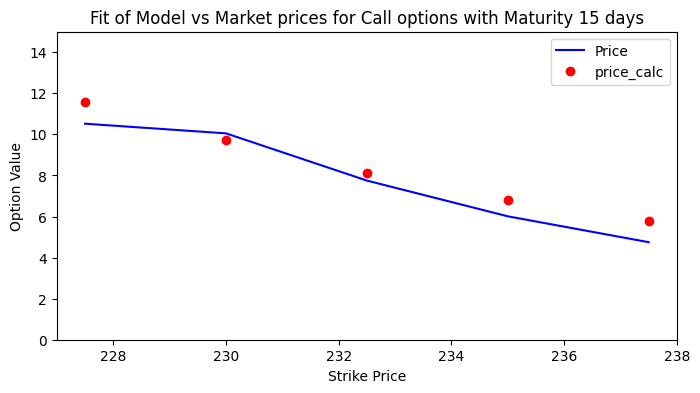

In [39]:
generate_plot(options, "C", 15)

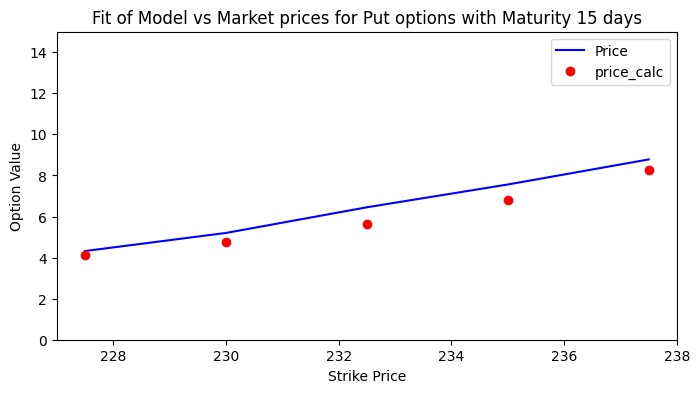

In [40]:
generate_plot(options, "P", 15)

Analysing the graphs above we can conclude that the parameters we have found using calibration process fit the actual market prices relatively well. Estimated errors are: MSE = 0.48 and RMSE of ~0.7. Visual inspection of Put and Call graphs demonstrates that the model produses values close to the maket data. The only noticeable difference is Deep Out of the Money call option.

## 1.c Using Monte-Carlo method for Asian call option pricing

In [41]:
import numpy as np
from scipy.stats import norm

def heston_asian_mc(S0, K, T, r, v0, kappa, theta, sigma, rho, n_steps, n_sims, option_type='call'):
    """
    Price an Asian option using Monte Carlo simulation with the Heston model.

    Parameters:
    S0 (float): Initial stock price
    K (float): Strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate
    v0 (float): Initial volatility
    kappa (float): Rate of mean reversion in variance process
    theta (float): Long-term mean variance
    sigma (float): Volatility of volatility
    rho (float): Correlation between stock price and variance processes
    n_steps (int): Number of time steps in simulation
    n_sims (int): Number of simulation paths
    option_type (str): 'call' for Call option, 'put' for Put option

    Returns:
    float: Estimated option price
    """
    dt = T / n_steps
    np.random.seed(0)
    # Generate correlated random numbers
    z1 = np.random.normal(0, 1, (n_steps, n_sims))
    z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, (n_steps, n_sims))

    # Initialize arrays
    S = np.zeros((n_steps + 1, n_sims))
    v = np.zeros((n_steps + 1, n_sims))
    S[0] = S0
    v[0] = v0

    # Simulate stock price and variance paths
    for i in range(1, n_steps + 1):
        S[i] = S[i-1] * np.exp((r - 0.5 * v[i-1]) * dt + np.sqrt(v[i-1] * dt) * z1[i-1])
        v[i] = np.maximum(v[i-1] + kappa * (theta - v[i-1]) * dt + sigma * np.sqrt(v[i-1] * dt) * z2[i-1], 0)

    # Calculate average stock price for each path
    S_avg = np.mean(S, axis=0)

    # Calculate option payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(S_avg - K, 0)
    elif option_type.lower() == 'put':
        payoffs = np.maximum(K - S_avg, 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Calculate option price
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

S0 = 232.90
K = 232.90
T = 20 / 250
r = 0.015
n_steps = 20

# Heston (1993) model calibrated parameters
kappa_v = 5.37938150e+00
theta_v = 8.67728843e-02
sigma_v = 6.99666868e-06
rho = -6.11934338e-03
v0 = 8.72078281e-02

option_type = 'call'
n_sims = 10000

mc_asian_heston_call_price = heston_asian_mc(S0, K, T, r, v0, kappa_v, theta_v, sigma_v, rho, n_steps, n_sims, option_type=option_type)

print("Option price $%.2f" % mc_asian_heston_call_price)
print("Option price with 4 pct fee $%.2f" % (mc_asian_heston_call_price * 1.04))

Option price $4.53
Option price with 4 pct fee $4.71


# Step 2

## 2.A Calibration of Heston model with jumps (Bates, 1996) using Lewis (2001) approach

In [42]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import brute, fmin

def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options[options["Type"] == "C"].iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    mse_values.append(MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def B96_calibration():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [43]:
# General Parameters
S0 = 232.90
K = 100
T = 1
r = 0.05

# Previously calibraten parameters of Heston (1993) model with Lewis (2001) approach
kappa_v = 13.042
theta_v = 0.122
sigma_v = 0.0001
rho = -0.003
v0 = 0.045

df = pd.read_csv(r"Data\MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx - 1.csv")
options = df[(df["Days to maturity"] == 60)].copy()
for row, option in options.iterrows():
    T = (option["Days to maturity"] / 250.0) # 1 year = 250 trading days
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.015 # Constant Annual risk-free rate = 1.50%

i = 0
min_MSE = 5000.0
local_opt = False
mse_values = []

b96_params = B96_calibration()
b96_params

   0 | [ 0.  -0.5  0. ] |   3.738 |   3.738
  25 | [ 0.2  -0.5   0.25] |   1.485 |   1.485
  50 | [ 0.4 -0.5  0.5] |   6.612 |   1.317
  75 | [ 0.2   -0.2    0.525] |   1.321 |   1.317
 100 | [ 0.08566309 -0.02891711  0.86127058] |   1.180 |   1.170
 125 | [ 0.0626077  -0.00179791  0.98814916] |   1.148 |   1.148
 150 | [ 0.04128301 -0.00340358  1.22322747] |   1.127 |   1.125
 175 | [ 0.02335722 -0.00710819  1.4963491 ] |   1.107 |   1.105
 200 | [ 0.01057079 -0.0213949   1.90410606] |   1.086 |   1.083
 225 | [ 0.00885597 -0.02672171  2.01497052] |   1.075 |   1.075
 250 | [ 0.00476181 -0.04396591  2.28709421] |   1.069 |   1.068
 275 | [ 0.00431185 -0.04944931  2.34010791] |   1.066 |   1.066
 300 | [ 0.00288525 -0.06813474  2.50656754] |   1.063 |   1.063
 325 | [ 1.92038459e-03 -8.91797365e-02  2.67304408e+00] |   1.061 |   1.061
 350 | [ 1.22010824e-03 -1.10225230e-01  2.83894786e+00] |   1.060 |   1.059
 375 | [ 1.16861962e-03 -1.12920195e-01  2.85974465e+00] |   1.059 |   1.059

array([ 8.25204445e-05, -2.40953573e-01,  3.70428005e+00])

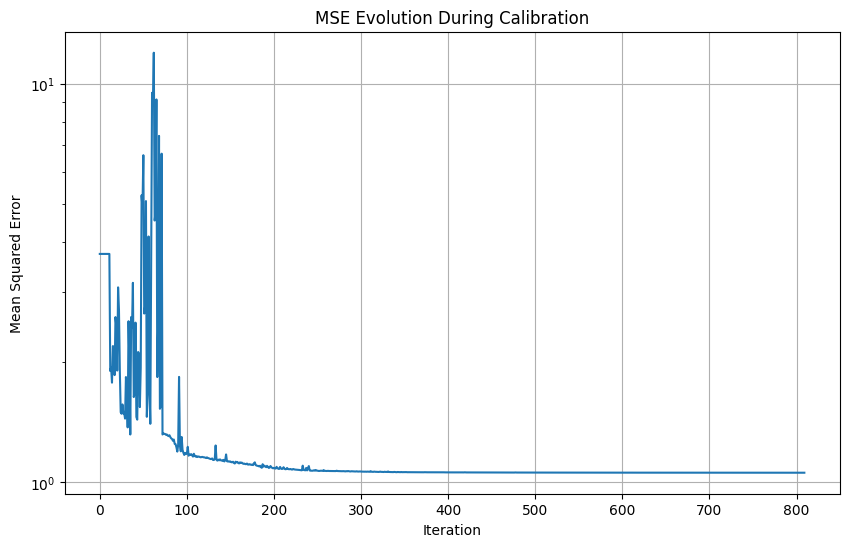

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(mse_values)), mse_values)
plt.title('MSE Evolution During Calibration')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.yscale('log')  # Use log scale for y-axis to better visualize improvements
plt.grid(True)
plt.show()

In [45]:
lambd, mu, delta = b96_params
lambd, mu, delta

(8.25204445319403e-05, -0.24095357290461622, 3.704280054252557)

Optimal parameters for Bates' (1996) jump component Merton (1976) with Lewis (2001) approach are
$$\lambda = 0.0000825$$
$$\mu = -0.2409$$
$$\delta = 3.704$$

## 2.B Calibrating Bates (1996) model using Carr Madan (1999) Approach

As our Client demanded that 60 days maturity would be better for her needs, we are going to use a different approach for calibration we are going to use the carr-Madan (1999) approach to Bates (1996)

As we have previously used Lewis (2001) Approach to calibrate the models, this time we are going to use Carr-Madan(1999) to bates (1996) for that we need bates characteristic function which is simply the product of characterstic function Heston model and Merton model Jump component.

As we have already discussed about Heston model charactertic function in Step 1 a. We are going to start with Merton Adjusted characteristic function where we will ony include the jump component.

### Merton (1976) Adjusted Characteristic Function (Only Jump Component)

In order to produce a stochastic volatility jump-diffusion model, we need to incorporate **only** the jump component of the Merton (1976) characteristic function.

The adjusted (only jump) characteristic function of Merton (1976) is therefore given by:
$$
\
\begin{equation*}
    \varphi^{M76J}_0 (u, T) = e^{\left( \left( i u \omega + \lambda ( e^{i u \mu_j - u^2 \delta^2/2}-1) \right) T \right)}
\end{equation*}
$$

where,
$$
\
\begin{equation*}
    \omega = - \lambda \left( e^{\mu_j + \delta^2/2}-1 \right)
\end{equation*}
$$
\
Now we will code the characteristic function:

In [46]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

### Bates (1996) Characteristic Function

This is the $\varphi^{B96}( )$ characteristic function of the bates model. which is the product of heston model and jump diffusion part of Merton model.
$$
\begin{equation*}
        \varphi^{B96}_0 (u, T) = \varphi^{H93}_0 \varphi^{M76J}_0 (u, T)
\end{equation*}
$$

Now we can combine both previous characteristic functions to produce the one we are interested in:

In [47]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

### Pricing via Carr and Madan (1999)

Now we are going to price via carr-madan(1999) model. we can apply FFT to the integral in the call option price derived by Carr and Madan:
$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{B96} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$
\
Here we are going to use a numerical FFT routine and as was the case with the Lewis (2001) approach, we basically have to adapt the characteristic function we are considering to be the Bates (1996) one.

We also quickly used the put-call parity to write a Put call pricing function, then we used some general function to check wether our function are working well or not.

In [48]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

In [49]:
def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    call = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    Put = call + (K * np.exp(-r * T)) - S0

    return Put

In [50]:
# General Parameters
S0 = 100
K = 100
T = 1
r = 0.05

# Heston'93 Parameters
kappa_v = 1.5
theta_v = 0.02
sigma_v = 0.15
rho = 0.1
v0 = 0.01

# Merton'76 Parameters
lamb = 0.25
mu = -0.2
delta = 0.1
sigma = np.sqrt(v0)

i = 0
min_MSE = 500
min_MSE2 = 500

In [51]:
print(
    "B96 Call option price via FFT: $%10.4f"
    % B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
)

print(
    "B96 Put option price via FFT: $%10.4f"
    % B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
)

B96 Call option price via FFT: $    8.9047
B96 Put option price via FFT: $    4.0277


### Options Data Preprocessing

after that we moved into option data processing. We have already discussed data processing in Step 1 a. So we will not discuss anything more here but this time as our client has demanded for 60 days maturity so we are going to use data which has 60 days to maturity.

In [52]:
df = pd.read_csv(r"Data\MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx - 1.csv")
df.head()

,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


In [53]:
from skimpy import skim

skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 30     │ │ float64     │ 2     │                                                          │
│ │ Number of columns │ 4      │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Days to maturity    │   0 │     0 │     65 │  43.75 │     15 │     15 │     60 │    120 │    120 │ ▇ ▇  ▇  │  │
│ │ Strike              │   0 │     0 │  232.5 │  3.596 │  227.5 │    230 │  232.5 │    235 │  237.5 │ ▇▇ ▇▇▇  │  │
│ │ Price               │   0 │     0 │  14.07 │  6.124 │   4.32 │  9.098 │  14.93 │  17.54 │  27.92 │ ▇▅▆▇▂▂  │  │
│ └─────────────────────┴─────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Type                      │       0 │          0 │                            1 │                       30 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [54]:
S0 = 232.90


options = df[(df["Days to maturity"] == 60)].copy()

In [55]:
for row, option in options.iterrows():
    T = (option["Days to maturity"] / 250.0) # 1 year = 250 trading days
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.015      #Constant Annual risk-free rate = 1.50%

In [56]:
options.head()

,Days to maturity,Strike,Price,Type,T,r
5,60,227.5,16.78,C,0.24,0.015
6,60,230.0,17.65,C,0.24,0.015
7,60,232.5,16.86,C,0.24,0.015
8,60,235.0,16.05,C,0.24,0.015
9,60,237.5,15.10,C,0.24,0.015


### Calibrating Heston (1993) stochastic volatility model

Now we are going to start our claibration process.

we are going to start with  $\varphi^{H93}_0$  which stands for characteristic function of Heston (1993). Thus, our first task in calibrating the Bates (1996) model will be to calibrate Heston (1993) model to observed market data. we have done something similar in step 1 a. So we are going to do the same thing again but with days to maturity of 60 days.

Now, we will introduce the same error function again that will evaluate the error the model makes with respect to observed data given certain parameters. As usual, we will rely on a mean squared error (MSE) function. We will also define some initial values for the calibration parameters:

In [57]:
i = 0
min_MSE = 500
min_MSE2 = 500

In [58]:
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE, min_MSE2
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    se2 = []

    for row, option in options.iterrows():
      if option["Type"] == "C":
            model_value = H93_call_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
            )
            se.append((model_value - option["Price"]) ** 2)

      if option["Type"] == "P":
            model_value = H93_call_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
            )
            se2.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    MSE2 = sum(se2) / len(se2)

    min_MSE = min(min_MSE, MSE)
    min_MSE2 = min(min_MSE2, MSE2)

    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| Call MSE: %7.3f | Min Call MSE: %7.3f" % (MSE, min_MSE))
        print("%4d |" % i, np.array(p0), "| Put MSE: %7.3f | Min Put MSE: %7.3f" % (MSE2, min_MSE2))

    i += 1

    return MSE + MSE2

Again, we are going to use the same function that performs the optimization process. In other words, it optimizes the model parameters so as to minimize the error function with respect to market data.

we will use the same steps that is to use brute function of Scipy , that allows the calibration to focus on most sensible ranges. Once ranges are declared, we can dig deeper into the specific regions and get the actual parameters more accurately with the fmin function.



In [59]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

Now, let's see the performance of our calibration algorithm. For that, we just need to call our H93_calibration_full() function. This will give us each of the different outputs from calibration, including the values given to the different parameters in the model.

In [60]:
Para = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | Call MSE: 124.804 | Min Call MSE: 124.804
   0 | [ 2.5   0.01  0.05 -0.75  0.01] | Put MSE:  76.656 | Min Put MSE:  76.656
 100 | [ 2.5   0.04  0.05 -0.5   0.02] | Call MSE:  74.670 | Min Call MSE:  58.694
 100 | [ 2.5   0.04  0.05 -0.5   0.02] | Put MSE:  41.844 | Min Put MSE:  31.966
 200 | [ 7.5   0.02  0.25 -0.25  0.03] | Call MSE:  76.370 | Min Call MSE:  58.668
 200 | [ 7.5   0.02  0.25 -0.25  0.03] | Put MSE:  43.060 | Min Put MSE:  31.791
 300 | [ 9.21694329e+00  6.78192087e-02  3.91683465e-02 -1.65139018e-03
  3.44282888e-02] | Call MSE:  28.307 | Min Call MSE:  28.307
 300 | [ 9.21694329e+00  6.78192087e-02  3.91683465e-02 -1.65139018e-03
  3.44282888e-02] | Put MSE:  16.008 | Min Put MSE:  16.008
 400 | [ 1.30048138e+01  1.23311948e-01  7.54349574e-03 -4.73537003e-03
  4.38142629e-02] | Call MSE:   3.629 | Min Call MSE:   1.621
 400 | [ 1.30048138e+01  1.23311948e-01  7.54349574e-03 -4.73537003e-03
  4.38142629e-02] | Put MSE:  13.857

In [61]:
Para

array([ 1.30421001e+01,  1.22500576e-01,  1.33016664e-05, -3.82725595e-03,
        4.53972818e-02])

Now we have finally calibrated our parameters to market values.

The results from this calibration give us the following values for the parameters in the Heston (1993) model:

$\kappa_\nu = 13.042$

$\theta_\nu = 0.122$

$\sigma_\nu = 0.000$

$\rho = -0.003$

$\nu_0 = 0.045$

The next step will be simply using these parameters to use in the final Bates model calibration.

### Calibrate jump component in Bates (1996)

Now we will move to claibrating the Merton model Jump diffusion component, we will gain start with an error function which will be looking at differences between market and model prices for the complete Bates (1996) model:

We are also going to use the same carr-madan (1999) pricing function of call and put options via bates (1996) model.

In [62]:
i = 0
min_MSE = 5000.0
min_MSE2 = 5000.0
local_opt = False

In [63]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1, min_MSE2
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    se2 = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
        model_value = B96_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Price"]) ** 2)

      if option["Type"] == "P":
        model_value = B96_put_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se2.append((model_value - option["Price"]) ** 2)


    MSE = sum(se) / len(se)
    MSE2 = sum(se2) / len(se2)

    min_MSE = min(min_MSE, MSE)
    min_MSE2 = min(min_MSE2, MSE2)

    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
        print("%4d |" % i, np.array(p0), "| Put MSE: %7.3f | Min Put MSE: %7.3f" % (MSE2, min_MSE2))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + MSE2 + penalty
    return MSE + MSE2

Finally, we can create our functions to calibrate the jump component of the model:

In [64]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

Let's execute this optimization to see the values for the jump component calibration:

In [65]:
params = B96_calibration_short()

   0 | [ 0.  -0.5  0. ] | 118.817 | 118.817
   0 | [ 0.  -0.5  0. ] | Put MSE:  80.178 | Min Put MSE:  80.178
  25 | [ 0.2  -0.5   0.25] |  76.476 |  74.718
  25 | [ 0.2  -0.5   0.25] | Put MSE:  45.342 | Min Put MSE:  43.942
  50 | [ 0.4 -0.5  0.5] |  37.352 |  37.352
  50 | [ 0.4 -0.5  0.5] | Put MSE:  16.068 | Min Put MSE:  16.009
  75 | [ 5.0e-01 -5.0e-01  2.5e-04] |  23.283 |  20.320
  75 | [ 5.0e-01 -5.0e-01  2.5e-04] | Put MSE:   6.974 | Min Put MSE:   5.315
 100 | [ 6.74086934e-01 -5.48315329e-01  3.38348765e-04] |   5.414 |   4.504
 100 | [ 6.74086934e-01 -5.48315329e-01  3.38348765e-04] | Put MSE:   1.586 | Min Put MSE:   0.747
 125 | [ 9.84562212e-01 -3.72007279e-01  9.13590567e-04] |   5.165 |   4.504
 125 | [ 9.84562212e-01 -3.72007279e-01  9.13590567e-04] | Put MSE:   1.045 | Min Put MSE:   0.747
 150 | [ 1.33153797 -0.2860966   0.0029084 ] |   4.989 |   3.662
 150 | [ 1.33153797 -0.2860966   0.0029084 ] | Put MSE:   0.606 | Min Put MSE:   0.538
 175 | [ 1.72652362 -0.240

In [66]:
params

array([ 3.44569822e+00, -1.73263719e-01,  1.20222545e-09])

After Calibrating we got the following jump components yields:

λ = 3.445

μ = -0.173

δ = 0.000



### Model vs Market prices after jump claibration

Now we will check the performance of our jump calibrated model.

we will create a function that yields the model values under the different parameters obtained in the calibration process:

In [67]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
        model_value = B96_call_FFT(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

Here we will plot our results

In [68]:
def plot_calibration_results(p0):

    options_t = options[(options["Type"] == 'C')]
    options_t["Model"] = B96_jump_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity 60 days")
    plt.ylabel("option values")
    plt.plot(options_t.Strike, options_t.Price, "b", label="market")
    plt.plot(options_t.Strike, options_t.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options_t.Strike) - 5,
            max(options_t.Strike) + 5,
            min(options_t.Price) - 5,
            max(options_t.Price) + 5,
        ]
    )

    plt.subplot(212)
    plt.grid()
    wi = 1.0
    diffs = options_t.Model.values - options_t.Price.values
    plt.bar(options_t.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options_t.Strike) - 5,
            max(options_t.Strike) + 5,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

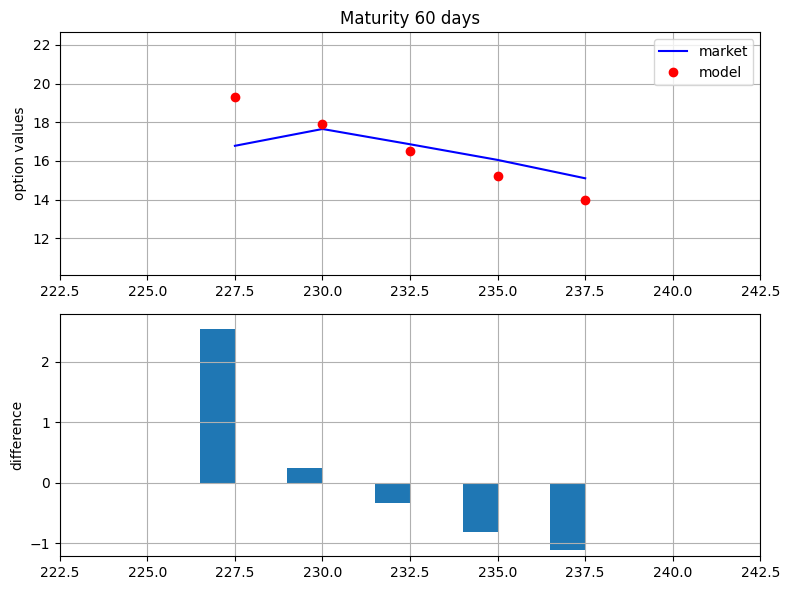

In [69]:
plot_calibration_results(params)

### Full Bates (1996) model calibration

Now we are here in our Final step i.e Full calibration of Bates (1996) model.

As we have already got out calibrated parameters from both the components which is from the stochastic volatility model ($\kappa_\nu$, $\theta_\nu$, $\sigma_\nu$, $\rho$, $\nu_0$), but also those from the jump component ($λ$, $\mu$, $\delta$).

Hence, our $p_0$ is defined as:

In [70]:
kappa_v = 13.04
theta_v = 0.12
sigma_v = 0.
rho = -0.003
v0 = 0.045
lamb = 3.44
mu = -0.17
delta = 0.

p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]
p0

[13.04, 0.12, 0.0, -0.003, 0.045, 3.44, -0.17, 0.0]

Now, we built up a B96_full_error_function that essentially takes these inputs and calculate the error function. Here we do not impose any penalties on the error function, as it solved an inherent problem of the jump diffusion model that should be already solved by using the initial inputs from the jump component calibration.

Now. Let's define our error function:

In [71]:
i = 0
min_MSE = 5000.0
min_MSE2 = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE, min_MSE2
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    se2 = []
    for row, option in options.iterrows():
        if option["Type"] == "C":
          model_value = B96_call_FFT(
              S0,
              option["Strike"],
              option["T"],
              option["r"],
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
        )
        se.append((model_value - option["Price"]) ** 2)

        if option["Type"] == "P":
          model_value = B96_put_FFT(
              S0,
              option["Strike"],
              option["T"],
              option["r"],
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
        se2.append((model_value - option["Price"]) ** 2)


    MSE = sum(se) / len(se)
    MSE2 = sum(se2) / len(se2)

    min_MSE = min(min_MSE, MSE)
    min_MSE2 = min(min_MSE2, MSE2)

    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
        print("%4d |" % i, np.array(p0), "| Put MSE: %7.3f | Min Put MSE: %7.3f" % (MSE2, min_MSE2))
    i += 1
    return MSE + MSE2

Next, the classic calibration we have done before for other models:

In [72]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

Now, we can see what are the different parameter values yielded by this calibration:

In [73]:
full_params = B96_calibration_full()

   0 | [ 1.304e+01  1.200e-01  0.000e+00 -3.000e-03  4.500e-02  3.440e+00
 -1.700e-01  0.000e+00] |     nan | 5000.000
   0 | [ 1.304e+01  1.200e-01  0.000e+00 -3.000e-03  4.500e-02  3.440e+00
 -1.700e-01  0.000e+00] | Put MSE:     nan | Min Put MSE: 5000.000


  25 | [ 1.30871445e+01  1.19873543e-01  2.36460686e-04 -2.97312641e-03
  4.53307829e-02  3.41629738e+00 -1.64487762e-01  9.38825607e-05] |  17.460 |  17.243
  25 | [ 1.30871445e+01  1.19873543e-01  2.36460686e-04 -2.97312641e-03
  4.53307829e-02  3.41629738e+00 -1.64487762e-01  9.38825607e-05] | Put MSE:  20.697 | Min Put MSE:  20.458
  50 | [ 1.33610911e+01  1.11146941e-01  8.49947601e-04 -3.18754744e-03
  4.96817380e-02  3.56346847e+00 -8.54112313e-02  1.13286434e-03] |   1.561 |   1.561
  50 | [ 1.33610911e+01  1.11146941e-01  8.49947601e-04 -3.18754744e-03
  4.96817380e-02  3.56346847e+00 -8.54112313e-02  1.13286434e-03] | Put MSE:   2.002 | Min Put MSE:   2.002
  75 | [ 1.35441466e+01  1.13066289e-01  1.16562962e-03 -3.23471914e-03
  5.17015662e-02  3.54646416e+00 -5.57712532e-02  1.42398534e-03] |   1.723 |   1.473
  75 | [ 1.35441466e+01  1.13066289e-01  1.16562962e-03 -3.23471914e-03
  5.17015662e-02  3.54646416e+00 -5.57712532e-02  1.42398534e-03] | Put MSE:   1.562 | Min Put

In [74]:
full_params

array([ 1.44520369e+01,  1.34036701e-01,  1.59918622e-03, -3.17038964e-03,
        4.86758427e-02,  3.15907383e+00, -1.00196527e-05,  1.96451143e-03])

we got the complete calibrated parameters :

- $\kappa_\nu = 14.452$
- $\theta_\nu = 0.134$
- $\sigma_\nu = 0.001$
- $\rho = -0.003$
- $\nu_0 = 0.048$
- $\lambda = 3.159$
- $\mu = -0.000$
- $\delta = 0.001$

Again we will see market vs model prices in full calibration and see the differences that our model produces using the parameters resulting from calibration, and compare those to observed market prices:

In [75]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
        model_value = B96_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

In [76]:
def plot_full_calibration_results_full(p0):

    options_t = options[(options["Type"] == 'C')]
    options_t["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity 60 days: Call options")
    plt.ylabel("option values")
    plt.plot(options_t.Strike, options_t.Price, "b", label="market")
    plt.plot(options_t.Strike, options_t.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options_t.Strike) - 5,
            max(options_t.Strike) + 5,
            min(options_t.Price) - 5,
            max(options_t.Price) + 5,
        ]
    )

    plt.subplot(212)
    plt.grid()
    wi = 1.0
    diffs = options_t.Model.values - options_t.Price.values
    plt.bar(options_t.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options_t.Strike) - 5,
            max(options_t.Strike) + 5,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

Here is the Market Vs model Calibration for call options data:

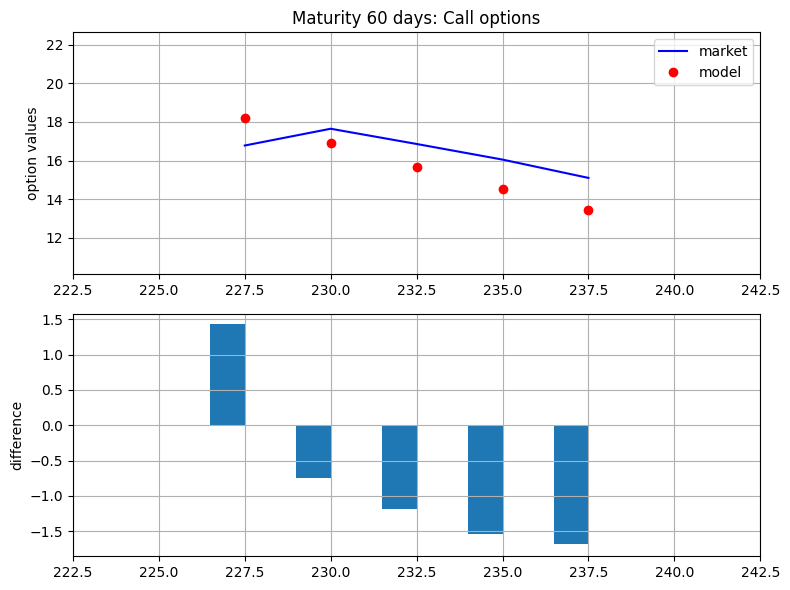

In [77]:
plot_full_calibration_results_full(full_params)

In [78]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
      if option["Type"] == "P":
        model_value = B96_put_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

In [79]:
def plot_full_calibration_results_full(p0):

    options_t = options[(options["Type"] == 'P')]
    options_t["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity 60 days : Put Options")
    plt.ylabel("option values")
    plt.plot(options_t.Strike, options_t.Price, "b", label="market")
    plt.plot(options_t.Strike, options_t.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options_t.Strike) - 5,
            max(options_t.Strike) + 5,
            min(options_t.Price) - 5,
            max(options_t.Price) + 5,
        ]
    )

    plt.subplot(212)
    plt.grid()
    wi = 1.0
    diffs = options_t.Model.values - options_t.Price.values
    plt.bar(options_t.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options_t.Strike) - 5,
            max(options_t.Strike) + 5,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

Here is the Market Vs model Calibration plot for Put options data:

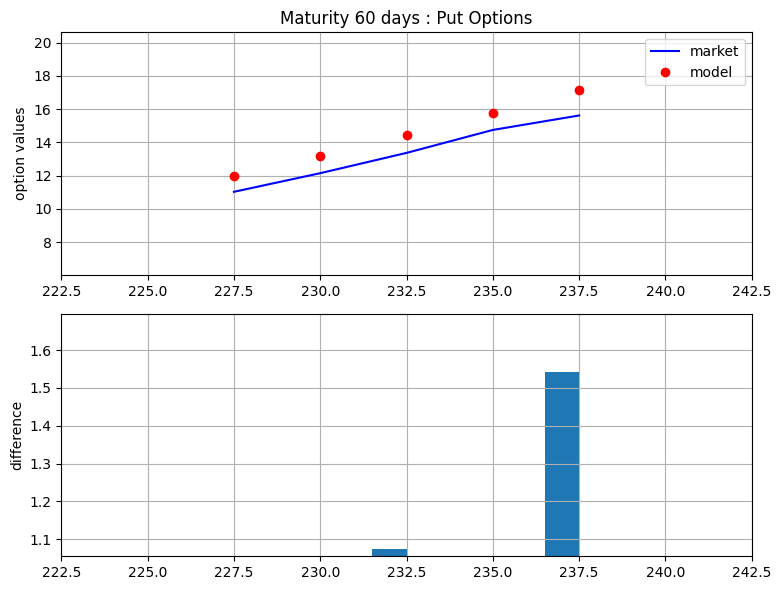

In [80]:
plot_full_calibration_results_full(full_params)

## 2.c Monte Carlo valuation of OTM Put option

In this section, we will price a Put option for "SM" with 70 days to maturity and a moneyness of 95% (strike price of 221.25). Since it is a Put option and the strike price is lower than the current price, the option is out-of-the-money (OTM).

Below are the input parameters required for valuing both call and put options using the Monte Carlo method. As the specific approach was not explicitly stated, we will use random path generation to determine option prices.

All parameters except volatility are provided in previous sections. Since the exact date of analysis is unknown, we cannot assess historical volatility based on market data. Therefore, as a proxy, we will use the implied volatility of the most similar option: an OTM Put with 60 days to maturity and a strike price of 227.5. Based on its price of 11.03, the implied volatility is calculated as follows:

In [81]:
#implied volatility

# Given market data
S0 = 232.90
K = 227.5
T = 60 / 250
r = 0.02
market_price = 11.03

from scipy.stats import norm
from scipy.optimize import newton

def black_scholes_put_price(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price of a European put option.

    Parameters:
    S : float : Current stock price
    K : float : Strike price
    T : float : Time to maturity (in years)
    r : float : Risk-free rate
    sigma : float : Volatility

    Returns:
    float : Black-Scholes price of the put option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def implied_volatility_put(price, S, K, T, r):
    """
    Calculate the implied volatility for a European put option using Newton-Raphson method.

    Parameters:
    price : float : Market price of the put option
    S : float : Current stock price
    K : float : Strike price
    T : float : Time to maturity (in years)
    r : float : Risk-free rate

    Returns:
    float : Implied volatility
    """
    def objective_function(sigma):
        return black_scholes_put_price(S, K, T, r, sigma) - price

    # Use Newton-Raphson method to find the root of the objective function
    implied_vol = newton(objective_function, x0=0.2, tol=1e-6)

    return implied_vol



# Calculate implied volatility
implied_volatilit = implied_volatility_put(market_price, S0, K, T, r)

print(f"The implied volatility is: {implied_volatilit:.4f}")

The implied volatility is: 0.3131


The implied volatility is 31.31%. To assess the price of the Put option, we will use this implied volatility instead of relying on historical volatility.

In [82]:
S0 = 232.90
K = 232.90 * 0.95
T = 70 / 250
r = 0.02
sigma = implied_volatilit  # Implied Volatility based on marke tdata
M = 10000    # Number of simulations
N = 70      # Number of time steps = days



def defmonte_carlo_call_option(S0, K, T, r, sigma, M, N, option_type):

    """
    Price an Europeran option using Monte Carlo simulation with the Heston model.

    Parameters:
    S0 (float): Initial stock price
    K (float): Strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of volatility
    n_steps (int): Number of time steps in simulation


    Returns:
    float: Estimated option price
    """

    # Time step
    dt = T / N

    # Simulate M paths of N steps each
    S = np.zeros((M, N + 1))
    S[:, 0] = S0

    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)


    # Calculate option payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(S[:, -1] - K, 0)
    elif option_type.lower() == 'put':
        payoffs = np.maximum(K - S[:, -1], 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Discounted average payoff
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price




option_type = 'put'

mc_call_price = defmonte_carlo_call_option(S0, K, T, r, sigma, M, N, option_type)

print(f"Option price {mc_call_price:.2f}")
print(f"Option price with 4% fee {mc_call_price * 1.04:.2f}")

Option price 9.24
Option price with 4% fee 9.61


Therefore based on the Monte-Carlo approach and using market data for implied volatility, the price of put option is 9.34$ and with 4% fees it is $9.72

# Step 3

## 3.A Calibrating CIR (1985) Model

As our client have very volatile demands, we must be ready to cater all their needs when necessary so we should be ready with the insights about the evolution of intrest rates in the long term.

For that we going to calibrate the CIR (1985) model which is an enhanced version of Vasicek (1977) model which includes a a term to make the
standard deviation of short rate changes proportional to √r. This yields the following SDE:

\
\begin{equation*}
  dr_t = k_r(\theta_r-r_t)dt + \sigma_r \sqrt{r_t} dz_t
\end{equation*}

\

Where the presence of $\sqrt{r_t}$ means that when the short rate increases, its standard deviation becomes higher.

CIR model have also different function components:

In this model, prices of ZCBs paying 1 monetary unit at T take the following form:
$$
\
\begin{equation*}
        B_0(T) = b_1(T) e^{-b_2(T)r_0}
\end{equation*}
$$
\
where
$$
\
\begin{equation*}
        b_1(T) = \left[ \frac{2\gamma e^{((k_r+\gamma)T/2)}}{ 2\gamma + (k_r +  \gamma)(e^{\gamma T}-1) } \right]^{\frac{2k_r\theta_r}{\sigma^2_r}}
\end{equation*}
$$
$$
\
\begin{equation*}
        b_2(T) = \frac{2(e^{\gamma T}-1)}{2\gamma + (k_r + \gamma)(e^{\gamma T}-1)}
\end{equation*}
$$
$$
\
\begin{equation*}
        \gamma = \sqrt{k^2_r + 2\sigma^2_r}
\end{equation*}
$$

AS now we have understood this model we are going to deal with model calibration in the following steps:

- Get market data
- Build up your valuation function according to your model
- Error function (difference between model output and observed market prices)
- Optimization function (minimizing error function)




### Getting Bond Market Data

For Market Data we are going to consider Euribor rates as we opearate mostly on an European setting.

The Rate are:

- 1 week = 0.648%
- 1 Month = 0.679%
- 3 months = 1.173%
- 6 months = 1.809%
- 12 months = 2.556%

We will divide the rates with 100 and maturaties with 360 to express it into decimal(rates), fraction of years(maturities)

In [83]:
mat_list = np.array(( 7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
)

### Bond Pricing and Forward Rates in CIR (1985) Model

\
When we perform our calibration, the goal is going to select model parameters ($\kappa_r$, $\theta_r$, $\sigma_r$, $r_0$) so to minimize the differences between the rates produced by the model, and the rates observed in practice. In other words, minimize $\Delta f(0, t)$:

$$
\
\begin{equation*}
    \Delta f(0, t) \equiv f(0, t) - f^{CIR}(0, t; \kappa_r, \theta_r, \sigma_r, r_0)
\end{equation*}
$$
\
where $f(0,t)$ is the current market implied forward rate between $0$ and time $t$. Formally, the forward rate from any time $t$ to $T$ is defined as:
$$
\
\begin{equation*}
   f(t,T) \equiv -\frac{\partial B_t(T)}{\partial T}
\end{equation*}
$$
\
Now, using the previous formula and the expressions we know from the CIR (1985) model, we can define the forward rate between times $t$ and $T$ and a set of parameters $\alpha$ in the following way:
$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$
\
Of course, the fact we are considering forward rates makes a lot of sense; since we are going to be projecting things into the future, we would like to calibrate the model to the actual forward rates implied by the ZCB prices.

Now, when using forward rates between two different times (e.g., $t$ and $T$), our bond valuation equation would slightly change in notation. You will realize that there are no major changes in the formula but, for the sake of completeness, we include them next  Svoboda (2002).
$$
\
\begin{equation*}
        B_t(T) = a(t,T) e^{-b(t,T)\mathbf{E_0^Q}(r_t)}
\end{equation*}
$$
\
where
$$
\
\begin{equation*}
        a(t, T) = \left[ \frac{2\gamma e^{((k_r+\gamma)(T-t)/2)}}{ 2\gamma + (k_r +  \gamma)(e^{\gamma (T-t)}-1) } \right]^{\frac{2k_r\theta_r}{\sigma^2_r}}
\end{equation*}
$$
$$
\
\begin{equation*}
        b(t, T) = \frac{2(e^{\gamma (T-t)}-1)}{2\gamma + (k_r + \gamma)(e^{\gamma (T-t)}-1)}
\end{equation*}
$$
\
with
$$
\
\begin{equation*}
    \mathbf{E_0^Q}(r_t) = \theta_r + e^{-\kappa_r t}(r_0- \theta_r)
\end{equation*}
$$
\
and, of course, still with $\gamma = \sqrt{k^2_r + 2\sigma^2_r}$.

\
Unfortunately, we do not typically get market quotes of the forward rates, which is what we need to properly execute our model calibration via minimizing $\Delta f(t,T)$ above for different $t$. Instead, we just have the yields (or rates) for different ZCBs and their maturities.

Luckily for us, there is a very simple way of going from bond yields to forward rates and vice versa (this, you should be familiar with even before the course). Suppose $Y(0, T)$ is the current bond yield (short rate) of a ZCB that pays 1 unit at maturity $T$:
$$
\
\begin{equation*}
    f(0, T) = Y(0, T) + \frac{\partial Y(0, T)}{\partial T}T
\end{equation*}
$$
\
Simultaneously, we know that the price of that bond today, given yield $Y(0, T)$ should solve the following equation:
$$
\
\begin{equation*}
    B_T(T) = B_0(T) e^{Y(0,T) T} \Leftrightarrow Y(0,T) = \frac{log B_T(T) - log B_0(T)}{T}
\end{equation*}
$$
\
and since we have normalized the face value of the bond at maturity to 1:
$$
\
\begin{equation*}
    Y(0,T) = -\frac{log B_0(T)}{T}
\end{equation*}
$$
\
Similarly, we can derive capitalization factors (the continuous yield of a unit ZCB) and equivalent annualized continuous rates. For example, capitalization factor, $f_s^{3m}$, for the 3 months Euribor rate, $Eur_{3m}$ would be:
$$
\
\begin{equation*}
    f_s^{3m} = 1 + 90/360 \times Eur_{3m}
\end{equation*}
$$
\
The equivalent annualized continuous rate, $f_c^{3m}$, is therefore defined as:
$$
\
\begin{equation*}
    f_c^{3m} = 360/90 \times log(f_s^{3m})
\end{equation*}
$$
\
which ensures the following relationship is satisfied:
$$
\
\begin{equation*}
    1 + 90/360 \times f_s^{3m} = e^{90/360 f^{3m}_c}
\end{equation*}
$$
\
So, now that we know all this, let's define the current short-term rate ($r_0$), the capitalization factors and the zero-forward rates implied by the Euribor rates observed in the market.

In [84]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

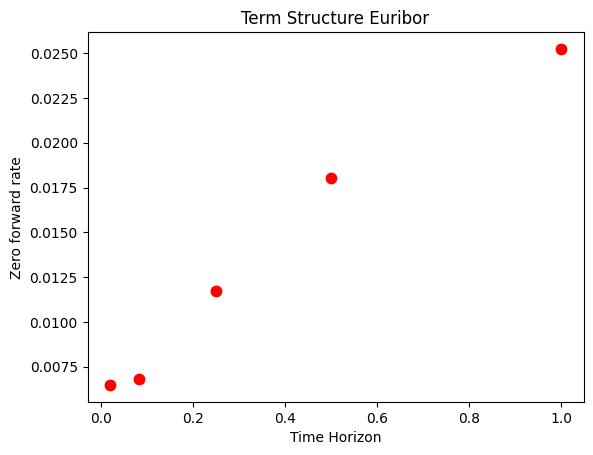

In [85]:
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

### Interpolation of Market Rates

Unfortunately, as we observe in the previous graph, there are a limited amount of rates quoted in the market. However, in order to calibrate the parameters of our model, we would like to have as many inputs (data points) as possible.

In order to do that, there is actually one common solution: interpolate the term structure of forward rates. This basically consists of fitting a function that can replicate the observed term structure and infer what would be the forward rate of a given maturity for which there is no market quote.

There are several ways to interpolate a term structure (e.g., linear interpolation, fitting a model such as Nelson-Siegel using OLS, etc). Here, we will use a common way of interpolation, which is cubic spline interpolation.

Now, we are going to take advantage of the scipy package in Python and its built-in spline functions `splrep` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep) and `splev` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splev.html#scipy.interpolate.splev).

We created 52 equally spaced maturites between 0 and 1 because we need to interpolate weekly rates for period of 12 months:

In [86]:
from scipy.interpolate import splev, splrep

In [87]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline

mat_list_n = np.linspace(
    0.0, 1.0, 52
)  # Create 52 equally spaced maturities between 0 and 1

inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline

f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

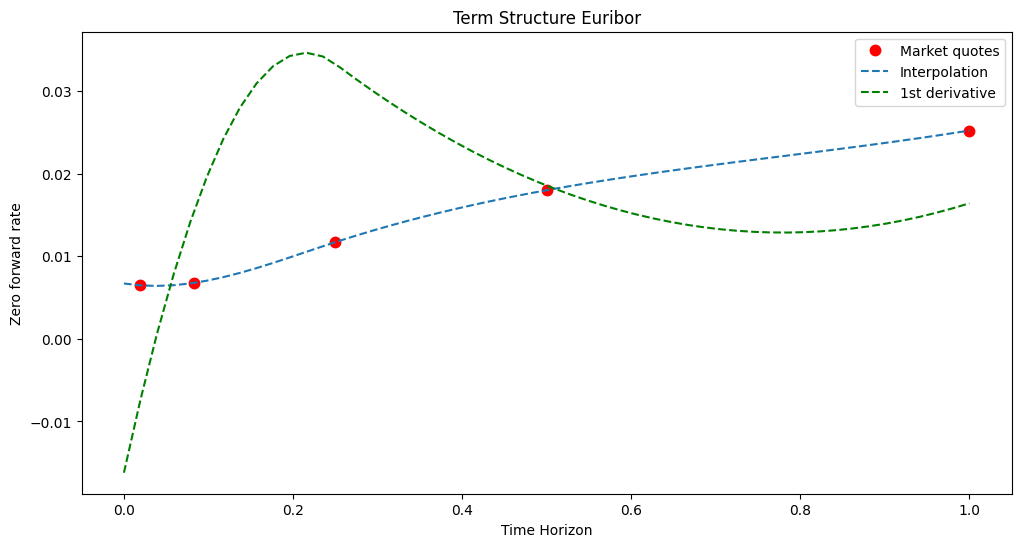

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

As you can see, we do not perfectly match the observed market data, but we are pretty close. In turn, we have many more data points that we can use to calibrate our interest rate model to observed (or, better said, interpolated from observed) market quotes.

### CIR forward rates

Finally, before jumping to the pure calibration, we wrote one last function. We will calibrate forward rates of the CIR (1985) model. Hence, we defined the forward rate expression in the CIR model, $f^{CIR}(t,T; \alpha)$. Remember that we have already seen this expression before:
$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$

In [89]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

### Error Function

Next, we will define our error function, which basically is equivalent to other error functions we have defined before. In this case, we are using Mean Squared Error (MSE). This is, given $\alpha$ equal to the set of parameters to calibrate:

$$
\
\begin{equation*}
  min \frac{1}{M} \sum_{m=0}^{M} \left( f(0,m\Delta t) - f^{CIR}(0,m\Delta t; \alpha) \right)^2
\end{equation*}
$$
\
with $M = T / \Delta t$, that is, the number of market data points between $0$ and $T$.

In [90]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

### Optimization

Finally, we just need to create our optimization function to minimize the difference between model and market rates, very much in the same spirit as we have done a few times before for other models:

In [91]:
from scipy.optimize import fmin

In [92]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

### Results

Now, we are ready to perform the whole calibration process as usual. First, let's run our calibration function to obtain the parameters:

In [93]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 142
         Function evaluations: 251


array([0.99872676, 0.10742899, 0.00100228])

we obtain parameters that closely match market data:

- $\kappa_r = 0.998$
- $\theta_r = 0.107$
- $\sigma_r = 0.001$

\
Then, let's see graphically the results of our calibration given the previous parameters:

In [94]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.01
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

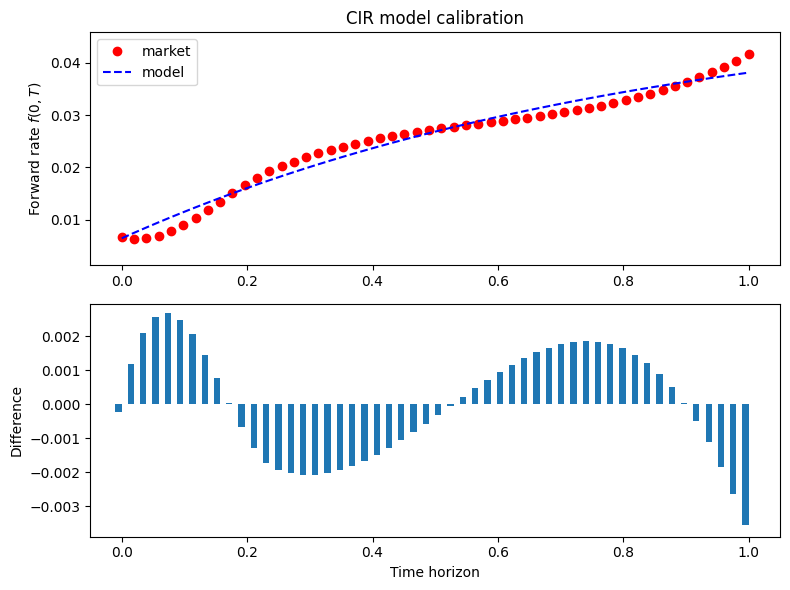

In [95]:
plot_calibrated_frc(params)

## 3.B Using CIR for Euribor daily rates simulations via Monte-Carlo

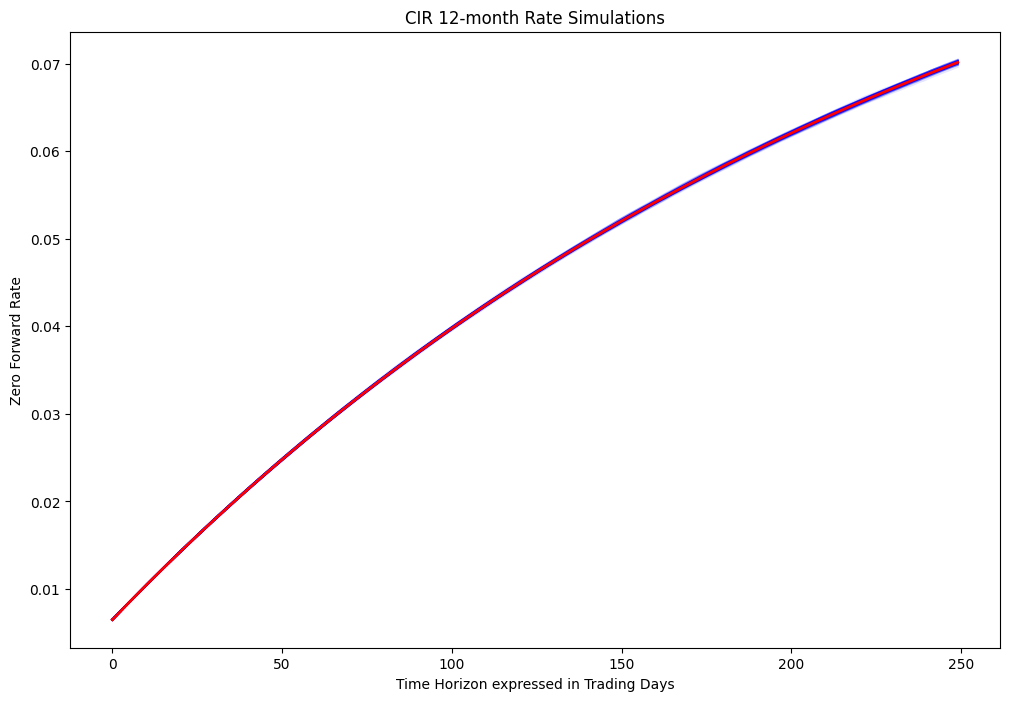

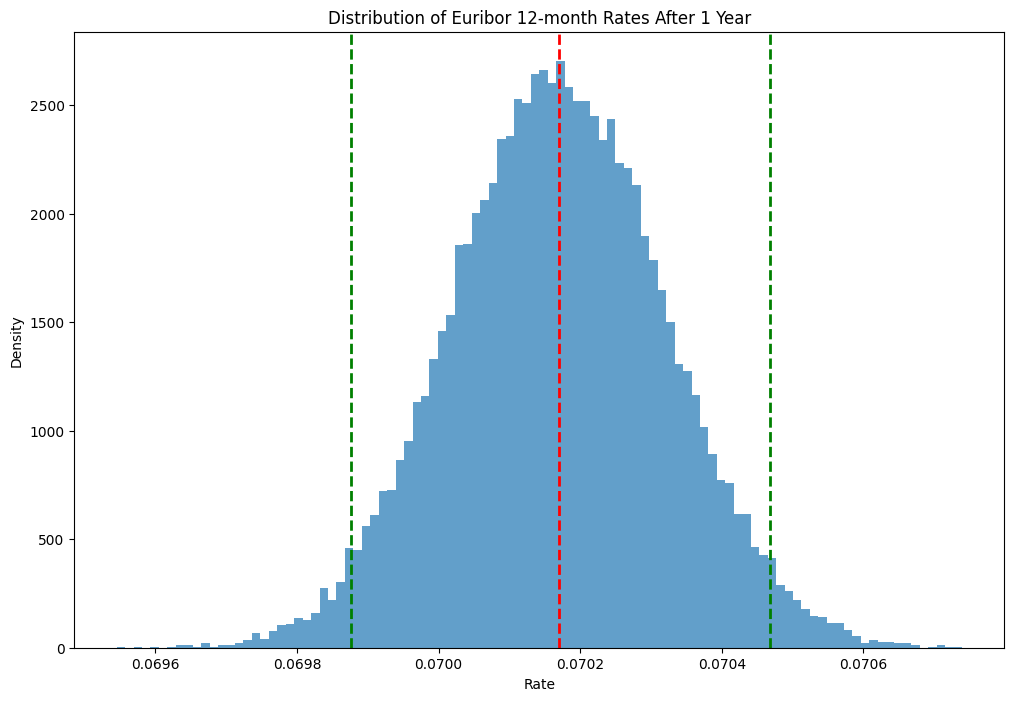

Expected 12-month Euribor rate in 1 year: 0.0702
95% Confidence Interval: [0.0699, 0.0705]


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

kappa, theta, sigma = params
r0 = rate_list[0]
T = 1
dt = 1/250
N = int(T/dt)
M = 30000

np.random.seed(42)
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

r = cir(r0, kappa, theta, sigma, T, N, M)

final_rates = r[-1, :]
expected_rate = np.mean(final_rates)
confidence_level = 0.95
lower_bound, upper_bound = np.percentile(final_rates, [(1-confidence_level)/2*100, (1+confidence_level)/2*100])

plt.figure(figsize=(12, 8))
plt.plot(r[:, :100], alpha=0.1, color='blue')
plt.plot(np.mean(r, axis=1), color='red', linewidth=2)
plt.title('CIR 12-month Rate Simulations')
plt.xlabel('Time Horizon expressed in Trading Days')
plt.ylabel('Zero Forward Rate')
plt.show()

plt.figure(figsize=(12, 8))
plt.hist(final_rates, bins=100, density=True, alpha=0.7)
plt.axvline(expected_rate, color='r', linestyle='dashed', linewidth=2)
plt.axvline(lower_bound, color='g', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='g', linestyle='dashed', linewidth=2)
plt.title('Distribution of Euribor 12-month Rates After 1 Year')
plt.xlabel('Rate')
plt.ylabel('Density')
plt.show()

print(f"Expected 12-month Euribor rate in 1 year: {expected_rate:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# **References**

- Gatheral, Jim. *The Volatility Surface: A Practitioner's Guide*. John Wiley & Sons Inc., 2006.

- Heston, Steven L. "A Closed-Form Solution for Options with Stochastic Volatility with Applications to Bond and Currency Options." *The Review of Financial Studies*, vol. 6, no. 2, 1993, pp. 327-343.

- Hilpisch, Yves. *Derivatives Analytics with Python: Data Analysis, Models,Simulation, Calibration and Hedging.* John Wiley & Sons, 2015.

- Bates, David S. 'Jumps and stochastic volatility: Exchange rate processes implicit in deutsche mark options'. The Review of Financial Studies 9.1 (1996): 69-107.

- Cherubini, Umberto, et al. Fourier transform methods in finance. John Wiley & Sons, 2010

- Galluccio, Stefano, and Yann Lecam. "Implied calibration and moments asymptotics in stochastic volatility jump diffusion models." Available at SSRN 831784 (2008).

- Cox, John C., et al. "An Intertemporal General Equilibrium Model of Asset Prices." *Econometrica: Journal of the Econometric Society*, 1985, pp. 363-384.

- Svoboda, Simona. *An Investigation of Various Interest Rate Models and Their Calibration in the South African Market.* 2002. University of the Witwatersrand, Dissertation. https://www.econbiz.de/Record/interest-rate-model-theory-with-reference-to-the-south-african-market-van-wijck-tjaart/10009442156